In [394]:
from collections import defaultdict, namedtuple
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats


In [395]:
phase_dir = '../phased_spark'
ped_file = '../data/spark.ped'

chrom = '21'
family_sizes = [4, 5, 6, 7]
build = '38'

In [396]:
cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0].startswith('chr'):
            cyto.append((pieces[0][3:], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

In [397]:
sample_to_affected = dict()
sample_to_sex = dict()

with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        sample_to_affected[pieces[1]] = pieces[5]
        sample_to_sex[pieces[1]] = pieces[4]
        
        

In [398]:

def pull_phase(phase_dir, chrom):
    # pull individuals
    sample_ids = set()
    family_to_inds = defaultdict(list)
    for family_size in family_sizes:
        with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, family_size), 'r') as f:
            next(f) # skip header
            for line in f:
                pieces = line.strip().split('\t')
                sample_ids.update(pieces[3:])
                family_to_inds[pieces[0]] = pieces[1:]
                
    sample_ids = sorted(sample_ids)
    sample_id_to_index = dict([(x, i) for i, x in enumerate(sample_ids)])
    print('samples', len(sample_id_to_index))
    
    # pull positions
    all_positions = set()
    for family_size in family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, family_size), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                start_pos, end_pos = [int(x) for x in pieces[(6+2*family_size):(8+2*family_size)]]
                if end_pos < start_pos:
                    print(start_pos, end_pos, pieces)
                assert end_pos >= start_pos
                
                all_positions.add(start_pos)
                all_positions.add(end_pos)
                
    all_positions = sorted(all_positions)
    position_to_index = dict([(x, i) for i, x in enumerate(all_positions)])
    print('positions', len(position_to_index))
    
    # pull phase data
    # sample, position
    mat_phase_data = -np.ones((len(sample_id_to_index), len(position_to_index)), dtype=int)
    pat_phase_data = -np.ones((len(sample_id_to_index), len(position_to_index)), dtype=int)
    for family_size in family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, family_size), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                start_pos, end_pos = [int(x) for x in pieces[(6+2*family_size):(8+2*family_size)]]
                state = np.array([int(x) for x in pieces[1:(6+2*family_size)]])
                inds = family_to_inds[family_key]
                child_indices = [sample_id_to_index[x] for x in inds[2:]]
                
                if True: #state[-1] == 0:
                    for child_index, state_index in zip(child_indices, np.arange(8, 4+2*len(inds), 2)):
                        mat_phase_data[child_index, (position_to_index[start_pos]):(position_to_index[end_pos]+1)] = state[state_index]
                    for child_index, state_index in zip(child_indices, np.arange(9, 4+2*len(inds), 2)):  
                        pat_phase_data[child_index, (position_to_index[start_pos]):(position_to_index[end_pos]+1)] = state[state_index]
    
    
    return sample_ids, family_to_inds, all_positions, mat_phase_data, pat_phase_data


In [399]:
sample_ids, family_to_inds, all_positions, mat_phase_data, pat_phase_data = pull_phase(phase_dir, chrom)
sample_id_to_index = dict([(x, i) for i, x in enumerate(sample_ids)])


samples 1638
positions 3019


In [400]:
bonferonni_cutoff = -np.log10(0.05/np.sum((np.any(mat_phase_data[:, 1:] != mat_phase_data[:, :-1], axis=0)) | \
                                         (np.any(pat_phase_data[:, 1:] != pat_phase_data[:, :-1], axis=0))))
print(bonferonni_cutoff)

4.75815462196739


In [401]:
print(mat_phase_data.shape, np.tile([sample_to_affected[x]=='2' for x in sample_ids], 
                                            (len(all_positions), 1)).shape)

(1638, 3019) (3019, 1638)


In [402]:
print(np.unique(mat_phase_data, return_counts=True))
print(np.unique(pat_phase_data, return_counts=True))

(array([-1,  0,  1]), array([  10885, 3493577, 1440660]))
(array([-1,  2,  3]), array([   6896, 3536648, 1401578]))


In [403]:
# table of our test statistic
# family_size, max matching, position
mat_st = np.zeros((max(family_sizes)-1, max(family_sizes)-1, len(all_positions)))
pat_st = np.zeros((max(family_sizes)-1, max(family_sizes)-1, len(all_positions)))

mat_match = mat_phase_data == np.tile([sample_to_affected[x]=='2' for x in sample_ids], 
                                            (len(all_positions), 1)).T
pat_match = pat_phase_data == (2+np.tile([sample_to_affected[x]=='2' for x in sample_ids], 
                                            (len(all_positions), 1)).T)

for family_key, inds in family_to_inds.items():
    child_indices = [sample_id_to_index[x] for x in inds[2:]]
    
    no_missing = np.all(mat_phase_data[child_indices, :]>=0, axis=0)
    family_mat_match = np.sum(mat_match[child_indices, :], axis=0)
    max_family_mat_match = np.maximum(family_mat_match, len(inds[2:]) - family_mat_match)
    mat_st[len(inds[2:])*np.ones((np.sum(no_missing),), dtype=int), max_family_mat_match[no_missing], np.where(no_missing)[0]] += 1
    
    no_missing = np.all(pat_phase_data[child_indices, :]>=0, axis=0)
    family_pat_match = np.sum(pat_match[child_indices, :], axis=0)
    max_family_pat_match = np.maximum(family_pat_match, len(child_indices) - family_pat_match)
    pat_st[len(inds[2:])*np.ones((np.sum(no_missing),), dtype=int), max_family_pat_match[no_missing], np.where(no_missing)[0]] += 1
    

In [404]:
print(mat_st[2, :, :])

[[  0.   0.   0. ...   0.   0.   0.]
 [228. 228. 228. ... 224. 224. 224.]
 [246. 246. 246. ... 250. 250. 250.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [405]:
mat_pvalues = np.ones((len(all_positions),))
pat_pvalues = np.ones((len(all_positions),))
both_pvalues = np.ones((len(all_positions),))

for index in range(len(all_positions)):
    # mat
    obs = mat_st[:, :, index]
    num_fams = np.sum(obs, axis=1)

    exp = np.zeros(obs.shape)
    exp[2, :] = num_fams[2]*np.array([0, 1/2, 1/2, 0, 0, 0])
    exp[3, :] = num_fams[3]*np.array([0, 0, 3/4, 1/4, 0, 0])
    exp[4, :] = num_fams[4]*np.array([0, 0, 3/8, 4/8, 1/8, 0])
    exp[5, :] = num_fams[5]*np.array([0, 0, 0, 10/16, 5/16, 1/16])
    
    indices = np.where(exp>0)
    mat_pvalues[index] = scipy.stats.chisquare(obs[indices], exp[indices], ddof=3).pvalue
    
    # pat
    obs = pat_st[:, :, index]
    num_fams = np.sum(obs, axis=1)

    exp = np.zeros(obs.shape)
    exp[2, :] = num_fams[2]*np.array([0, 1/2, 1/2, 0, 0, 0])
    exp[3, :] = num_fams[3]*np.array([0, 0, 3/4, 1/4, 0, 0])
    exp[4, :] = num_fams[4]*np.array([0, 0, 3/8, 4/8, 1/8, 0])
    exp[5, :] = num_fams[5]*np.array([0, 0, 0, 10/16, 5/16, 1/16])
    
    indices = np.where(exp>0)
    pat_pvalues[index] = scipy.stats.chisquare(obs[indices], exp[indices], ddof=3).pvalue
    
    # both
    obs = mat_st[:, :, index]+pat_st[:, :, index]
    num_fams = np.sum(obs, axis=1)

    exp = np.zeros(obs.shape)
    exp[2, :] = num_fams[2]*np.array([0, 1/2, 1/2, 0, 0, 0])
    exp[3, :] = num_fams[3]*np.array([0, 0, 3/4, 1/4, 0, 0])
    exp[4, :] = num_fams[4]*np.array([0, 0, 3/8, 4/8, 1/8, 0])
    exp[5, :] = num_fams[5]*np.array([0, 0, 0, 10/16, 5/16, 1/16])
    
    indices = np.where(exp>0)
    both_pvalues[index] = scipy.stats.chisquare(obs[indices], exp[indices], ddof=3).pvalue

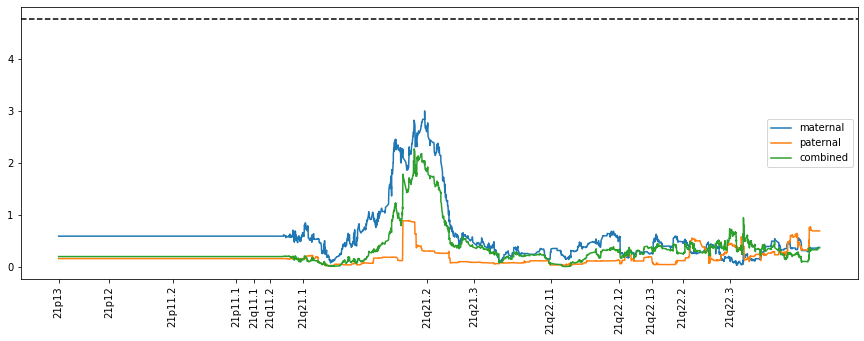

In [406]:
plt.figure(figsize=(15, 5))
plt.plot(all_positions, -np.log10(mat_pvalues), label='maternal')
plt.plot(all_positions, -np.log10(pat_pvalues), label='paternal')
plt.plot(all_positions, -np.log10(both_pvalues), label='combined')
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')

plt.legend()
plt.xticks([x[1] for x in cyto if x[0]==chrom], [chrom + x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.show()

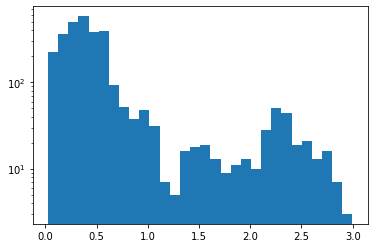

In [407]:
plt.hist(-np.log10(mat_pvalues), log=True, bins=30)
plt.show()